# 3 - Modelagem

Concluída a fase de exploração de dados, vamos agora modelá-los usando os padrões descobertos.

Nessa fase, buscaremos construir um modelo que, baseado nas variáveis contidas na base de dados de COVID, prediga o resultado de um teste para COVID.

In [41]:
# para carregar a base de dadas limpa
import pickle
from typing import Tuple, List

import numpy as np
import pandas as pd
from scipy import stats as spst
from tqdm import tqdm

# gráficos
import seaborn as sns
from matplotlib import rcParams, pyplot as plt

# parâmetros do matplotlib
# essencialmente, para deixar os gráficos maiores por padrão
rcParams['figure.dpi'] = 120
rcParams['figure.figsize'] = (10, 8)

# warnings
import warnings
warnings.filterwarnings("ignore")

# pacote com funções para análise desse projeto
import os
cwd = os.getcwd()
os.chdir("../")
import scripts.plots as splt, scripts.metrics as smetrics
os.chdir(cwd)

## Importação e checagem de integridade

Vamos importar os dados limpos e verificar a integridade dos mesmos.

In [42]:
with open(r'../data/covid_limpo.df', 'rb') as covidfile:
    pickler = pickle.Unpickler(file = covidfile)
    covid_full = pickler.load()

In [43]:
covid_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495062 entries, 0 to 499691
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   sex                  495062 non-null  category
 1   patient_type         495062 non-null  category
 2   pneumonia            495062 non-null  category
 3   age                  495062 non-null  int8    
 4   pregnancy            495062 non-null  category
 5   diabetes             495062 non-null  category
 6   copd                 495062 non-null  category
 7   asthma               495062 non-null  category
 8   inmsupr              495062 non-null  category
 9   hypertension         495062 non-null  category
 10  other_disease        495062 non-null  category
 11  cardiovascular       495062 non-null  category
 12  obesity              495062 non-null  category
 13  renal_chronic        495062 non-null  category
 14  tobacco              495062 non-null  category
 15  

In [44]:
covid_full.head()

,sex,patient_type,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res
id,,,,,,,,,,,,,,,,,
0,0,1,0,27,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,24,0,0,0,0,0,0,0,0,0,0,0,NaN,1
2,1,0,0,54,0,0,0,0,0,0,0,0,1,0,0,NaN,1
3,0,0,1,30,0,0,0,0,0,0,0,0,0,0,0,NaN,1
4,1,0,0,60,0,1,0,0,0,1,0,1,0,0,0,NaN,1


In [45]:
covid_full.covid_res.value_counts(normalize = True)

0    0.559096
1    0.440904
Name: covid_res, dtype: float64

## Construção dos possíveis modelos

Vamos construir os possíveis modelos, para então compará-los.

Cada modelo será um `Pipeline` onde entra a base de treino (`X_train`, `y_train`) e sai uma probabilidade de classificação. Para cada modelo, construiremos os passos dessa `Pipeline`.

### 0. Undersample

Como a base é muito grande, os modelos demoram bastante para serem treinados. Logo, para a investigação de qual modelo é melhor, vamos tomar 50.000 registros do modelo aleatoriamente (a base de dados completa tem por volta de 500.000). Dessa forma, aceleramos a investigação sem perdermos muita potência estatística.

In [46]:
n_samples = 50_000
covid = covid_full.sample(n_samples)

### 1. Tratamento dos dados faltantes

Como falamos na seção de análise exploratória dos dados, tínhamos três opções para tratamento dos dados faltantes no campo `contact_other_covid` (A):

1. Remover os registros correspondentes;
2. Codificar os dados faltantes como uma nova categoria; ou
3. Remover o campo da análise.

Além disso, também cogitamos remover os campos cuja frequência da classe positiva é muito baixa (B), a saber:

* `inmsupr`
* `copd`
* `renal_chronic`
* `cardiovascular`
* `other_disease`
* `asthma`

Perfazemos portanto 6 pré-processadores. Vamos agora implementá-los.

In [47]:
from sklearn.model_selection import train_test_split
# função para separar bases diferentes em treino e teste

def train_test_split_base(
    base: pd.DataFrame,
    test_size: float,
    target: str,
    stratify: bool = True
) -> Tuple:
    
    base = base.copy()

    X = base.drop(columns = [target])
    y = base[target]

    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size = test_size,
            stratify = y,     # não é estritamente necessário pois a base é razoavelmente balanceada
        )
    
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size = test_size,
        )

    return base, (X_train, X_test, y_train, y_test)

In [48]:
bases = {}
tts_tuples = {}   # train test split
test_size = 0.4


#### 1. Remover os registros correspondentes, manter os campos de comorbidades

In [49]:
alternativa = 'contact_dropna_comorb'

bases[alternativa], tts_tuples[alternativa] = train_test_split_base(
    base = covid.dropna(),
    test_size = test_size,
    target = 'covid_res',
    stratify = True,
)

#### 2. Codificar os dados faltantes como uma nova categoria, manter os campos de comorbidades

In [50]:
alternativa = 'contact_nacat_comorb'

base = covid.copy()
base['contact_other_covid'] = base['contact_other_covid'].cat.codes.astype('category')

bases[alternativa], tts_tuples[alternativa] = train_test_split_base(
    base = base,
    test_size = test_size,
    target = 'covid_res',
    stratify = True,
)

#### 3. Eliminar o campo `contact_other_covid` da análise, manter os campos de comorbidades

In [51]:
alternativa = 'contact_drop_comorb'

bases[alternativa], tts_tuples[alternativa] = train_test_split_base(
    base = covid.drop(columns = 'contact_other_covid'),
    test_size = test_size,
    target = 'covid_res',
    stratify = True,
)

#### 4. Remover os registros correspondentes, eliminar os campos de comorbidades

In [52]:
alternativa = 'contact_dropna_comorb_drop'

drop_cols = [ 'copd', 'asthma', 'inmsupr', 'other_disease', 'cardiovascular', 'renal_chronic' ]


bases[alternativa], tts_tuples[alternativa] = train_test_split_base(
    base = covid.drop(columns = drop_cols).dropna(),
    test_size = test_size,
    target = 'covid_res',
    stratify = True,
)

#### 5. Codificar os dados faltantes como uma nova categoria, eliminar os campos de comorbidades

In [53]:
alternativa = 'contact_nacat_comorb_drop'

base = covid.drop(columns = drop_cols).copy()
base['contact_other_covid'] = base['contact_other_covid'].cat.codes.astype('category')

bases[alternativa], tts_tuples[alternativa] = train_test_split_base(
    base = base,
    test_size = test_size,
    target = 'covid_res',
    stratify = True,
)

#### 6. Eliminar o campo `contact_other_covid` da análise, eliminar os campos de comorbidades

In [54]:
alternativa = 'contact_drop_comorb_drop'

bases[alternativa], tts_tuples[alternativa] = train_test_split_base(
    base = covid.drop(columns = drop_cols + ['contact_other_covid']),
    test_size = test_size,
    target = 'covid_res',
    stratify = True,
)

### Modelo

Vamos agora construir os `Pipelines` com os modelos.

Primeiramente, vamos construir as partes comuns a todos os modelos:

1. Colunas numéricas: `age`. Para esta, usaremos o `StandardScaler` para normalizar os dados.

In [55]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# pipeline das colunas numéricas
pipeline_numericas = Pipeline(steps = [
    ('scaler_std', StandardScaler()),
])

2. Colunas categóricas: `sex`, `patient_type`, `pneumonia`, `diabetes`, `copd`, `asthma`, `inmsupr`, `hypertension`, `other_diseases`, `cardiovascular`, `obesity`, `renal_chronic`, `tobacco` e `contact_other_covid`. Para essas usaremos o `OneHotEncoder` para tratar antes de enviar ao modelo.

In [56]:
# pipeline das colunas categoricas
pipeline_categoricas = Pipeline( steps = [
    ('onehot', OneHotEncoder(handle_unknown = 'ignore')),
])

Vamos agora juntar todos em um passo só através do `ColumnTransformer`:

In [57]:
from sklearn.compose import ColumnTransformer

def montar_separador_numericas_categoricas(
    pipeline_numericas, 
    pipeline_categoricas,
    train_test_split_tuple: tuple,
):  
    X_train, X_test, y_train, y_test = train_test_split_tuple

    # nome das colunas numericas e categoricas
    features_numericas = X_train.select_dtypes(exclude = ['object', 'category']).columns
    features_categoricas = X_train.select_dtypes(include = ['object', 'category']).columns

    # separador: os dados entram no pipeline e são separados em dois, cada um vai em um pipeline diferente
    separador = ColumnTransformer(transformers = [
        ('numericas', pipeline_numericas, features_numericas),
        ('categoricas', pipeline_categoricas, features_categoricas)
    ])

    return separador

Por fim, vamos construir automaticamente os modelos.

Para cada alternativa para o campo `contact_other_covid`, vamos gerar um `Pipeline` com os modelos

* KNN;
* Regressão Logística;
* Árvore de Decisão;
* XGBoost; e
* Random Forests,

para então treiná-los.

In [58]:
# modelos
from sklearn.neighbors import KNeighborsClassifier as KNNClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from copy import deepcopy

# para que a cada rodada os valores permaneçam os mesmos
random_seed = 42

def montar_pipeline(
    steps_antes_estimador: list,
    model_name: str, 
    model,
    train_test_split_tuple: tuple,
    pipeline_class = Pipeline,
) -> Pipeline:

    X_train, X_test, y_train, y_test = train_test_split_tuple

    # ... montar os passos do pipeline final de cada modelo ...
    steps_final = steps_antes_estimador + [ (model_name, model) ]

    # ... e criar a pipeline, fit, predict, predict_proba
    model = deepcopy(pipeline_class(steps = steps_final))
    model.fit(
        X_train,
        y_train
    )

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # retornar a Pipeline completa, as predições com threshold 50% e as probabilidades
    return model, y_pred, y_prob


In [59]:
%%time
# GO!

# armazenamento dos classificadores, predições, probabilidades e tuplas tts
clfs = {}
y_preds = {}
y_probs = {}
train_test_splits = {}

# para cada estratégia de pre-processamento...
for preproc_name in bases.keys():
    # ... para cada modelo...
    for model_name, model in zip(
        ['knn', 'logistic', 'decision_tree', 'random_forest', 'xgboost'],
        [
            KNNClassifier(), 
            LogisticRegression(random_state = random_seed), 
            DecisionTreeClassifier(random_state = random_seed), 
            RandomForestClassifier(random_state = random_seed), 
            XGBClassifier(random_state = random_seed, eval_metric = 'logloss')
    ]):
        print(f"Trabalhando com estratégia de preproc '{preproc_name}' e modelo '{model_name}'... ", end = '')

        separador = montar_separador_numericas_categoricas(
            pipeline_numericas = pipeline_numericas,
            pipeline_categoricas = pipeline_categoricas,
            train_test_split_tuple = tts_tuples[preproc_name]
        )

        steps_antes_estimador = [ ('separador', separador) ]

        clf, y_pred, y_prob = montar_pipeline(
            steps_antes_estimador = steps_antes_estimador,
            model_name = model_name, 
            model = model,
            train_test_split_tuple = tts_tuples[preproc_name]
        )

        nome_final = f'{preproc_name}__{model_name}'

        train_test_splits[nome_final] = tts_tuples[preproc_name]
        clfs[nome_final] = clf
        y_preds[nome_final] = y_pred
        y_probs[nome_final] = y_prob

        print('OK.')

Trabalhando com estratégia de preproc 'contact_dropna_comorb' e modelo 'knn'... OK.
Trabalhando com estratégia de preproc 'contact_dropna_comorb' e modelo 'logistic'... OK.
Trabalhando com estratégia de preproc 'contact_dropna_comorb' e modelo 'decision_tree'... OK.
Trabalhando com estratégia de preproc 'contact_dropna_comorb' e modelo 'random_forest'... OK.
Trabalhando com estratégia de preproc 'contact_dropna_comorb' e modelo 'xgboost'... OK.
Trabalhando com estratégia de preproc 'contact_nacat_comorb' e modelo 'knn'... OK.
Trabalhando com estratégia de preproc 'contact_nacat_comorb' e modelo 'logistic'... OK.
Trabalhando com estratégia de preproc 'contact_nacat_comorb' e modelo 'decision_tree'... OK.
Trabalhando com estratégia de preproc 'contact_nacat_comorb' e modelo 'random_forest'... OK.
Trabalhando com estratégia de preproc 'contact_nacat_comorb' e modelo 'xgboost'... OK.
Trabalhando com estratégia de preproc 'contact_drop_comorb' e modelo 'knn'... OK.
Trabalhando com estratégi

## Avaliação dos modelos construídos

Com os modelos montados, vamos compará-los.

A performance de classificação depende do critério de decisão, dadas as probabilidades que o modelo dá. O critério de escolha do melhor modelo deve levar em consideração essas probabilidades.

Vamos compará-lo portanto usando 3 métricas

* **AUROC**: área sob a curva ROC - quanto maior, mais o modelo discrimina entre as classes;
* ***Brier loss***: quanto menor, mais calibradas estão as probabilidades aos dados; e
* ***Log loss***: quanto menor, mais calibradas estão as probabilidaes aos dados.

### Construção do *classification report*

Vamos chamar a função `classification_report` para ter um resumo das principais métricas de cada um dos 15 modelos fitados.

In [60]:
from sklearn.metrics import classification_report

# para cada modelo...
for (full_name, clf), y_pred, y_prob, tts in zip(
    clfs.items(), y_preds.values(), y_probs.values(), train_test_splits.values()
):
    y_test = tts[3]
    preproc_name, model_name = full_name.split('__')
    # plotar o clf report
    print('---------')
    print(f"Modelo: '{model_name}' (preproc: '{preproc_name}')")
    print('--> ')
    print(classification_report(
        y_true = y_test,
        y_pred = y_pred
    ))

---------
Modelo: 'knn' (preproc: 'contact_dropna_comorb')
--> 
              precision    recall  f1-score   support

           0       0.64      0.74      0.69      8224
           1       0.51      0.40      0.44      5554

    accuracy                           0.60     13778
   macro avg       0.58      0.57      0.57     13778
weighted avg       0.59      0.60      0.59     13778

---------
Modelo: 'logistic' (preproc: 'contact_dropna_comorb')
--> 
              precision    recall  f1-score   support

           0       0.65      0.90      0.75      8224
           1       0.66      0.28      0.39      5554

    accuracy                           0.65     13778
   macro avg       0.65      0.59      0.57     13778
weighted avg       0.65      0.65      0.61     13778

---------
Modelo: 'decision_tree' (preproc: 'contact_dropna_comorb')
--> 
              precision    recall  f1-score   support

           0       0.64      0.85      0.73      8224
           1       0.56      0

### Curva ROC

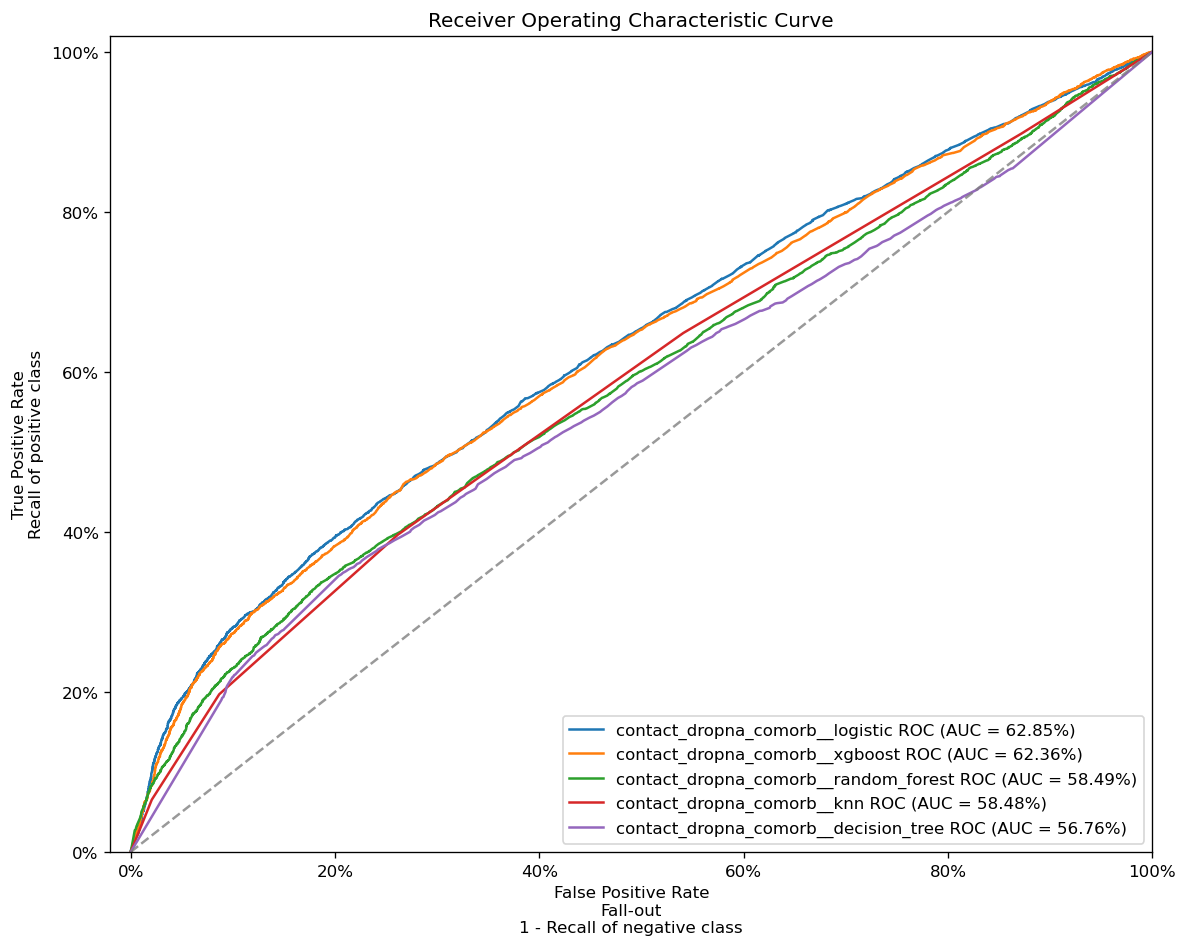

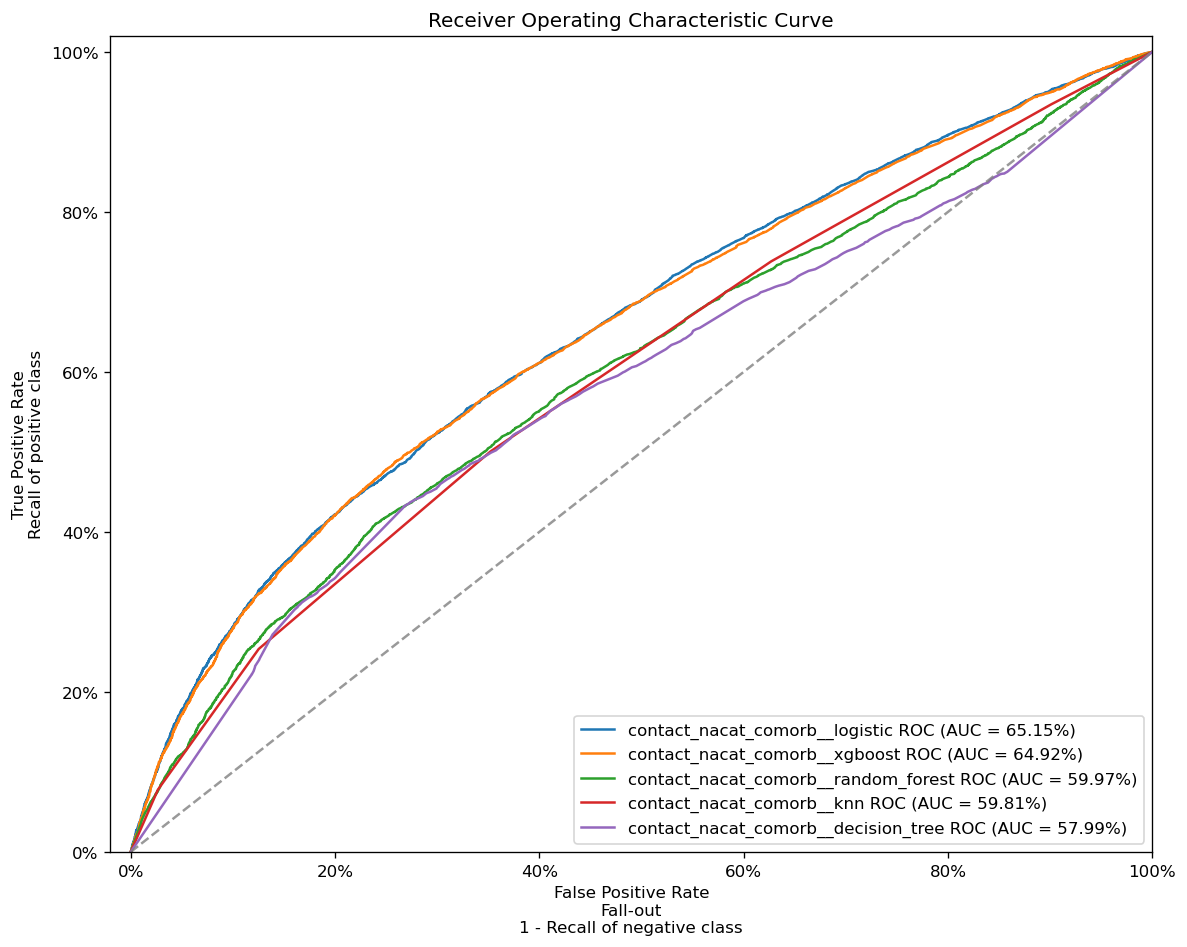

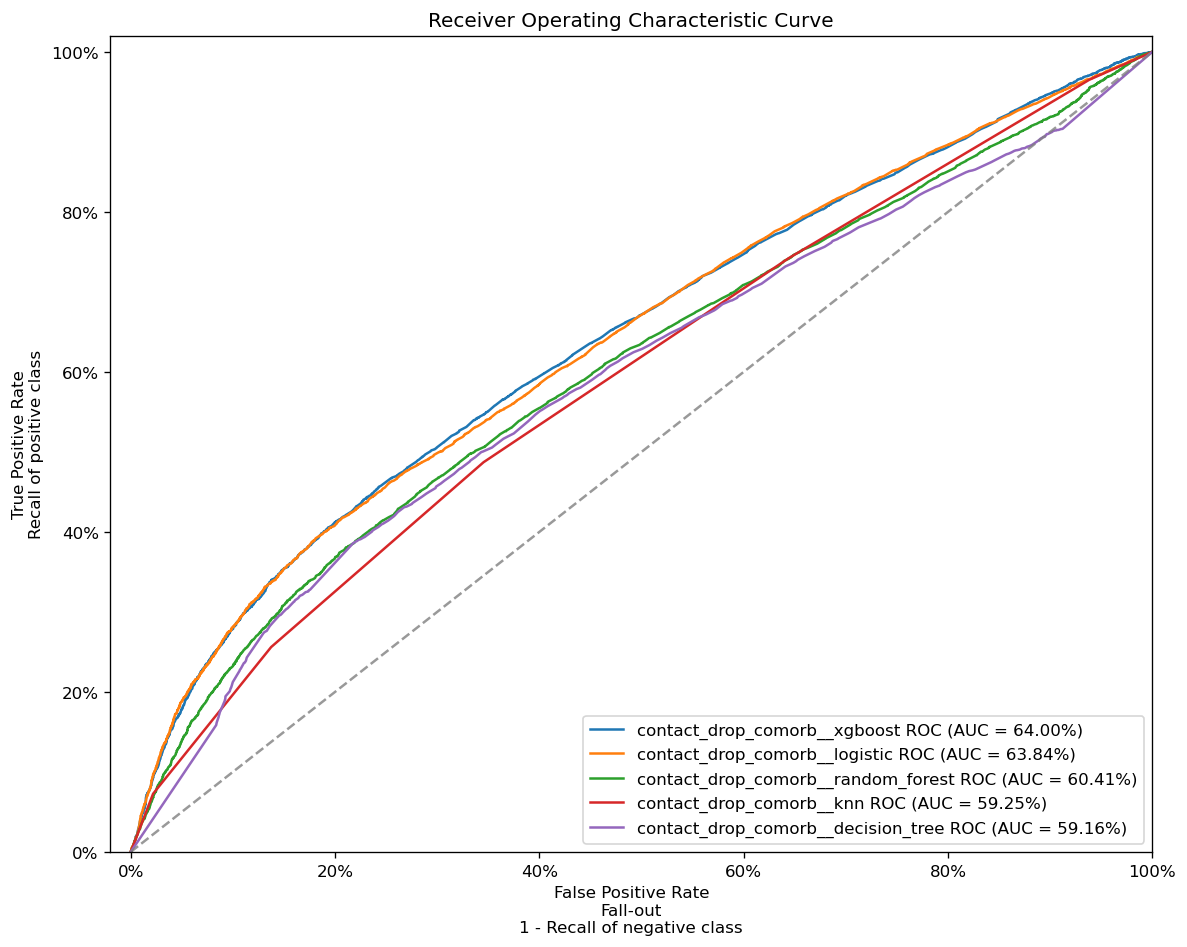

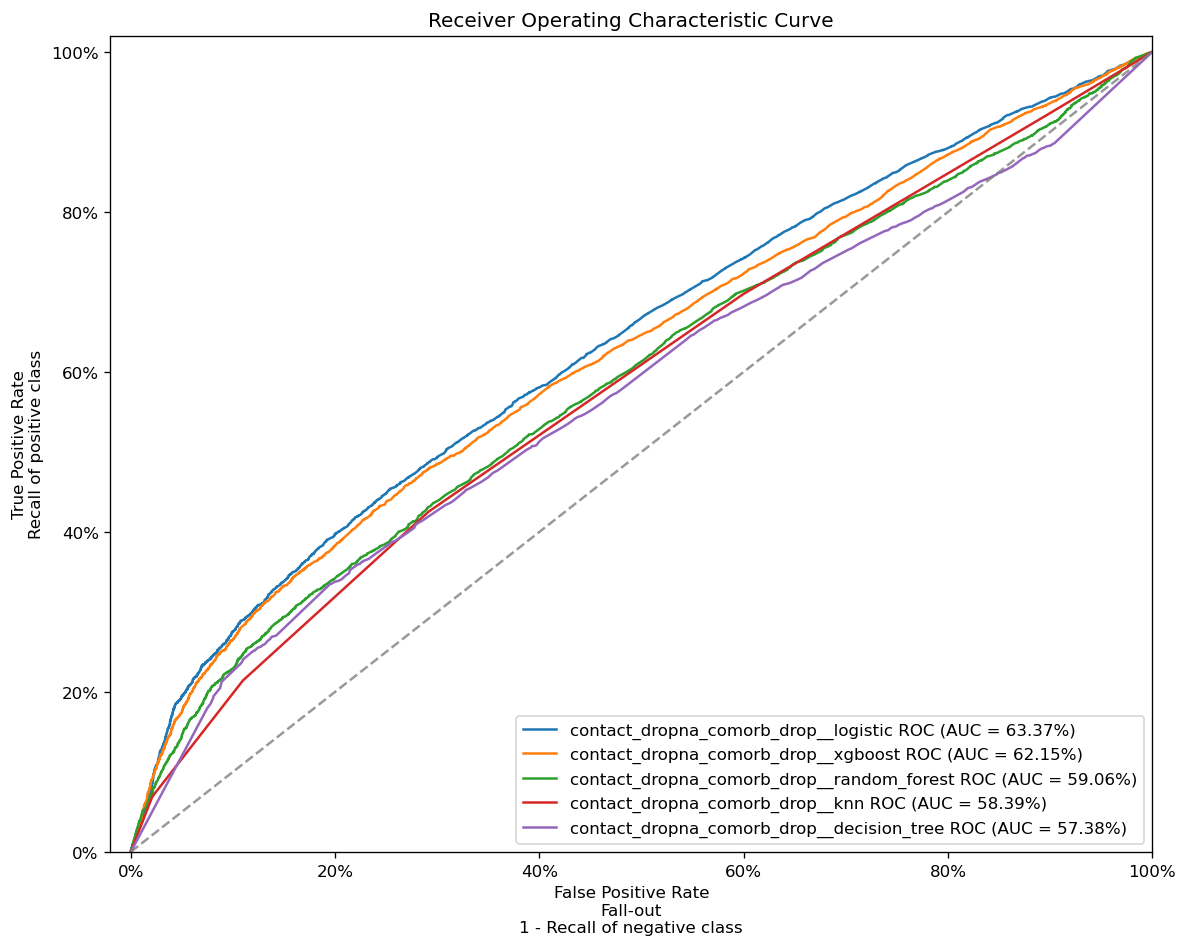

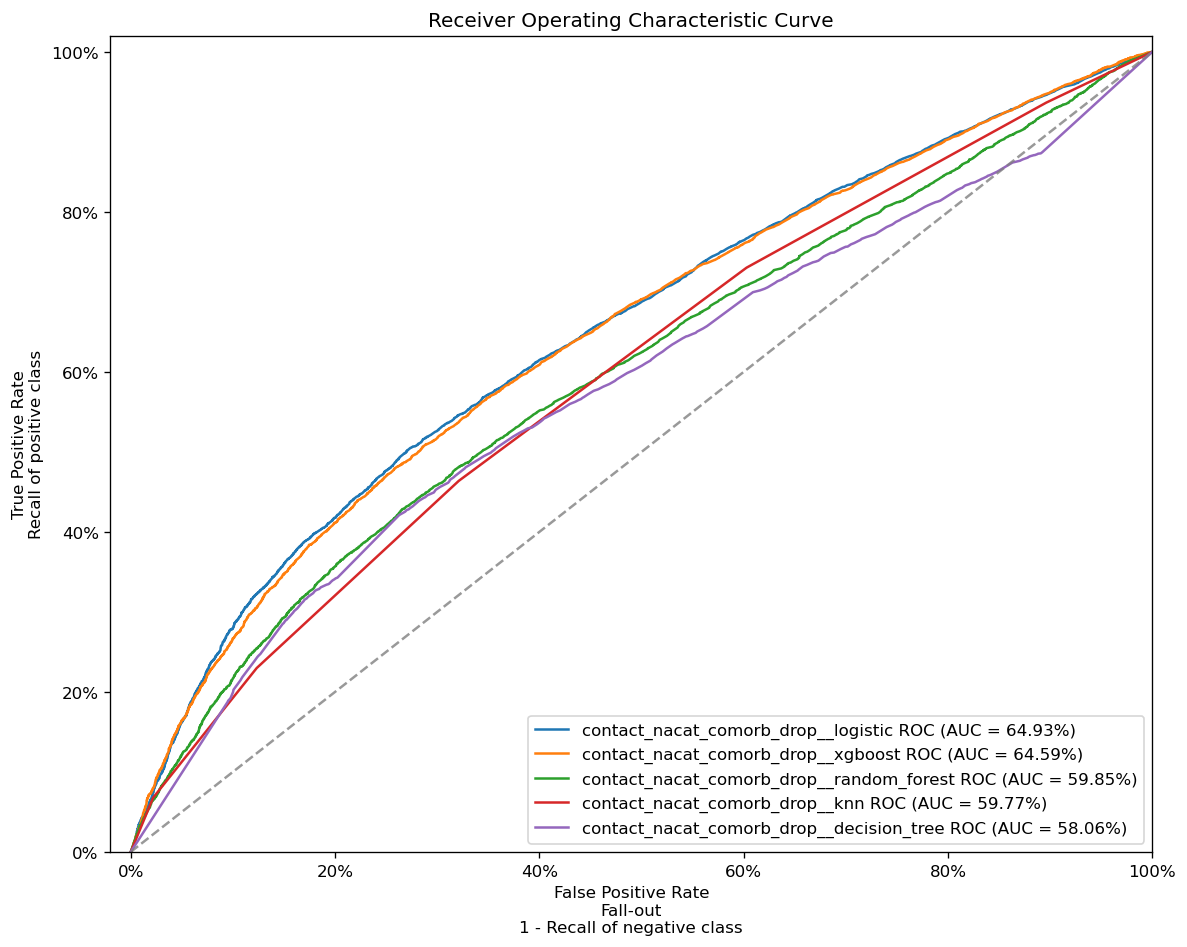

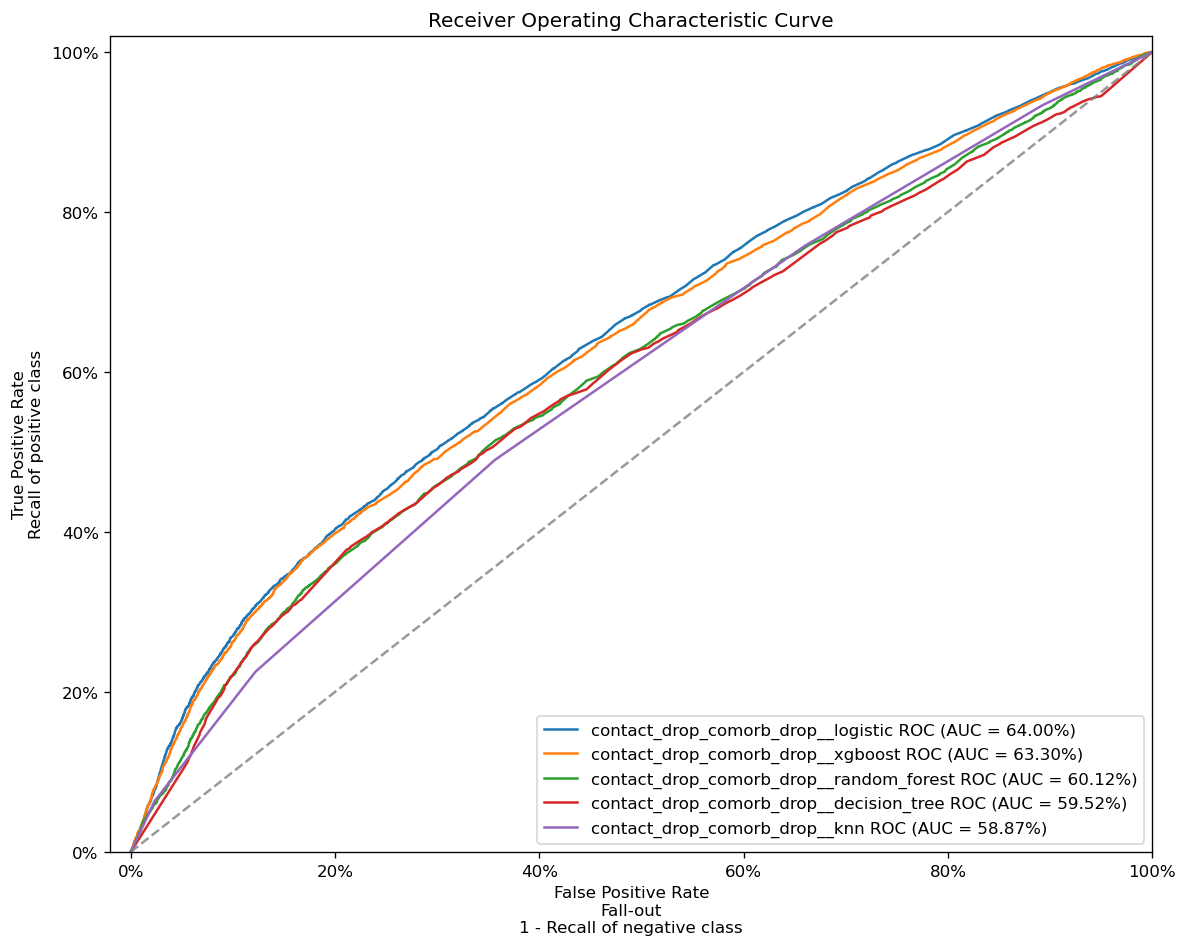

In [61]:
from pprint import pprint

model_ranks = {}
for preproc_name, tts in tts_tuples.items():

    clfs_preproc = { full_name: clf for full_name, clf in clfs.items() if full_name.startswith(f'{preproc_name}__') }

    # transformers = { full_name: clf.steps[0][1].transformers for full_name, clf in clfs.items() if full_name.startswith(preproc_name) }
    # print(f'{preproc_name} X_test columns = {tts[1].columns}')
    # pprint(transformers)

    model_ranks[preproc_name] = splt.plot_roc_auc_curve(
        models = clfs_preproc,
        X_test = tts[1], y_test = tts[3],
    )

In [62]:
model_rank_all = (
    pd.concat(
        [ model_rank for model_rank in model_ranks.values() ]
    )
    .sort_values(by = 'brier', ascending = True)
)

preproc_model_idx = model_rank_all.index.str.split('__', expand = True)

preproc_model_idx.names = ('preproc', 'model_name')
model_rank_all.index = preproc_model_idx

model_rank_all

,,model,auroc,brier,logloss,f1,precision,recall,accuracy
preproc,model_name,,,,,,,,
contact_dropna_comorb_drop,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.633741,0.224225,0.640309,0.381438,0.653275,0.269355,0.647844
contact_dropna_comorb,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.628452,0.224859,0.641866,0.392992,0.655042,0.280699,0.650457
contact_nacat_comorb,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.651503,0.227539,0.647041,0.476967,0.645499,0.378219,0.6344
contact_dropna_comorb,xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.623629,0.228015,0.651893,0.406326,0.626407,0.300684,0.645812
contact_dropna_comorb_drop,xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.621461,0.228291,0.652158,0.406163,0.622536,0.301404,0.644723
contact_nacat_comorb_drop,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.649255,0.228376,0.64901,0.480239,0.644989,0.38253,0.63505
contact_drop_comorb,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.638409,0.229406,0.651083,0.463549,0.643938,0.36211,0.6306
contact_nacat_comorb,xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.649151,0.229536,0.654077,0.499112,0.62734,0.414407,0.6334
contact_drop_comorb,xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.640036,0.230031,0.653671,0.470065,0.640078,0.371412,0.6309


In [63]:
model_rank_all.sort_values(by = 'auroc', ascending = False)

,,model,auroc,brier,logloss,f1,precision,recall,accuracy
preproc,model_name,,,,,,,,
contact_nacat_comorb,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.651503,0.227539,0.647041,0.476967,0.645499,0.378219,0.6344
contact_nacat_comorb_drop,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.649255,0.228376,0.64901,0.480239,0.644989,0.38253,0.63505
contact_nacat_comorb,xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.649151,0.229536,0.654077,0.499112,0.62734,0.414407,0.6334
contact_nacat_comorb_drop,xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.645926,0.230569,0.65549,0.498005,0.616544,0.417697,0.62885
contact_drop_comorb,xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.640036,0.230031,0.653671,0.470065,0.640078,0.371412,0.6309
contact_drop_comorb_drop,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.639952,0.230119,0.652581,0.457678,0.634553,0.357913,0.62615
contact_drop_comorb,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.638409,0.229406,0.651083,0.463549,0.643938,0.36211,0.6306
contact_dropna_comorb_drop,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.633741,0.224225,0.640309,0.381438,0.653275,0.269355,0.647844
contact_drop_comorb_drop,xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.632999,0.23256,0.659175,0.468275,0.625403,0.374248,0.6254


## Conclusões

### Modelo / Estimador

Independentemente da estratégia de pré-processamento, **os modelos de regressão logística e *XGBoost* performaram melhor que os outros**.

O AUROC dos dois está acima de 62%, enquanto que os outros estão abaixo de 60%. Separando por cada estratégia de pré-processamento, a média da diferença entre o AUROC do modelo logístico/XGBoost e dos outros é de ~3-4%.

Além disso, a calibragem de probabilidades dos dois modelos está significativamente melhor que os outros. O *Brier score* dos dois está abaixo de 0.23, enquanto que o dos outros está acima de 0.25 (menor é melhor). A *logloss* está abaixo de 0.66, enquanto que a dos outros está acima de 0.91.

**Estes dois modelos (regressão logística e XGBoost) seguem para tentativas de otimização**.

### Estratégia de pré-processamento

A respeito da escolha da estratégia de pré-processamento, ainda não temos um vencedor claro.


In [64]:
idx = pd.IndexSlice
model_rank_all.loc[idx[:, ['logistic', 'xgboost']], :].sort_values(by = 'auroc', ascending = False)

,,model,auroc,brier,logloss,f1,precision,recall,accuracy
preproc,model_name,,,,,,,,
contact_nacat_comorb,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.651503,0.227539,0.647041,0.476967,0.645499,0.378219,0.6344
contact_nacat_comorb_drop,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.649255,0.228376,0.64901,0.480239,0.644989,0.38253,0.63505
contact_nacat_comorb,xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.649151,0.229536,0.654077,0.499112,0.62734,0.414407,0.6334
contact_nacat_comorb_drop,xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.645926,0.230569,0.65549,0.498005,0.616544,0.417697,0.62885
contact_drop_comorb,xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.640036,0.230031,0.653671,0.470065,0.640078,0.371412,0.6309
contact_drop_comorb_drop,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.639952,0.230119,0.652581,0.457678,0.634553,0.357913,0.62615
contact_drop_comorb,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.638409,0.229406,0.651083,0.463549,0.643938,0.36211,0.6306
contact_dropna_comorb_drop,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.633741,0.224225,0.640309,0.381438,0.653275,0.269355,0.647844
contact_drop_comorb_drop,xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.632999,0.23256,0.659175,0.468275,0.625403,0.374248,0.6254


#### Tratamento do campo `contact_other_covid`

O maior AUROC é o modelo de regressão logística com a estratégia de pré-processamento `contact_nacat` (codificar os `NaN` como uma categoria separada), mas a calibragem de probabilidades está ligeiramente melhor na estratégia `contact_dropna` (eliminar os registros em que `contact_other_covid` está faltando).

Apesar de a estratégia `contact_drop` (eliminar o campo `contact_other_covid` da análise) estar em "4° lugar" em termos de calibragem de análise, aparece como ótima alternativa em termos do AUROC.

Optamos no fim por **codificar os `NaN` como uma categoria a parte,** visto que o desempenho deste no AUROC foi superior e a diferença da performance na calibragem de probabilidades foi muito similar;

In [68]:
model_rank_all.loc[
    idx[
        ['contact_nacat_comorb', 'contact_nacat_comorb_drop'], 
        ['logistic', 'xgboost']
], :].sort_values(by = 'auroc', ascending = False)

,,model,auroc,brier,logloss,f1,precision,recall,accuracy
preproc,model_name,,,,,,,,
contact_nacat_comorb,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.651503,0.227539,0.647041,0.476967,0.645499,0.378219,0.6344
contact_nacat_comorb_drop,logistic,"(ColumnTransformer(transformers=[('numericas',...",0.649255,0.228376,0.64901,0.480239,0.644989,0.38253,0.63505
contact_nacat_comorb,xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.649151,0.229536,0.654077,0.499112,0.62734,0.414407,0.6334
contact_nacat_comorb_drop,xgboost,"(ColumnTransformer(transformers=[('numericas',...",0.645926,0.230569,0.65549,0.498005,0.616544,0.417697,0.62885


#### Eliminação de comorbidades

Sobre a opção por eliminar as comorbidades com baixa prevalência da classe positiva, não há muita diferença. 

No interesse da consistência, vamos utilizar o AUROC para selecionar. **Optamos portanto por não eliminar essas comorbidades da análise.**

### Em resumo...

No fim, optamos pelos modelos de **regressão logística e XGBoost** e pela estratégia de pré-processamento de
* **codificar os `NaN` como uma categoria a parte,** visto que o desempenho deste no AUROC foi superior e a diferença da performance na calibragem de probabilidades foi muito similar; e
* **não eliminar da análise as comorbidades com baixa prevalência (menor que 5%) da classe positiva.**

## Exportação dos modelos para otimização

Por fim, vamos exportar os dados para otimização.

In [72]:
model_export = {}

# codificar o nan como uma categoria separada e não dropar as comorbidades
preproc = 'contact_nacat_comorb'
models = ['logistic', 'xgboost']

# modelos: pipeline com o standardscaler e o onehotencoder
model_export['modelo'] = {
    model_name: model_rank_all.at[(preproc, model_name), 'model']
    for model_name in models
}

# train_test_split: tupla com 2 dataframes (X_train, X_test) e 2 series (y_train e y_test)
model_export['train_test_split'] = tts_tuples[preproc]

# base: df covid já transformado
model_export['base'] = bases[preproc]

In [73]:
# salvar via pickle

# with open(r'../models/modelo_default.model', 'wb') as modelfile:
#     pickler = pickle.Pickler(file = modelfile)
#     pickler.dump(model_export)